<a href="https://colab.research.google.com/github/skyish21/Smart-Energy-Usage/blob/main/Smart%20Energy%20Usage%20Forecasting%20and%20Optimization%20for%20Buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## “Smart Energy Usage Forecasting and Optimization for Buildings”

### 📄 Project Description
This project aims to forecast energy consumption in residential or commercial buildings using historical data, weather conditions, and occupancy patterns. The goal is to enable energy-efficient scheduling, demand prediction, and anomaly detection in line with Microsoft's focus on cloud-powered sustainability and smart cities.

Extend the project to:

1) Suggest optimal usage times

2) Trigger alerts for unusual consumption

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [62]:
# Load the dataset
df = pd.read_csv("/content/household_power_consumption.txt",
                 sep=';',
                 na_values='?',
                 low_memory=False)

# Preview
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [63]:
# Combine Date and Time into one DateTime column to mitigate bias
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

In [64]:
# set datetime as index value
df = df.set_index('DateTime')

In [65]:
# Remove old columns date and time
df = df.drop(['Date', 'Time'], axis=1)

In [66]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## EDA (Exploratory Data Analysis)

In [67]:
df.shape

(2075259, 7)

In [68]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [69]:
# Check data type for all columns
df.dtypes

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [70]:
# Convert all columns to numeric (turn ? or string to Nan)
df = df.apply(pd.to_numeric, errors='coerce')

In [71]:
# Look for missing values
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [72]:
df = df.dropna()

In [73]:
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [74]:
# Resample dataset by granularity - hourly, daily, weekly, monthly, yearly

def get_data_by_granularity(df, granularity):
    freq_map = {
        'hourly': 'H',
        'daily': 'D',
        'weekly': 'W',
        'monthly': 'M',
        'yearly': 'Y'
    }

    freq = freq_map.get(granularity.lower())

    if not freq:
        raise ValueError("Choose from: hourly, daily, weekly, monthly, yearly")

    return df.resample(freq).mean()

In [75]:
df_hourly = get_data_by_granularity(df, 'hourly')
df_daily = get_data_by_granularity(df, 'daily')
df_weekly = get_data_by_granularity(df, 'weekly')
df_monthly = get_data_by_granularity(df, 'monthly')
df_yearly = get_data_by_granularity(df, 'yearly')

/tmp/ipython-input-74-3519940021.py:17: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/tmp/ipython-input-74-3519940021.py:17: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/tmp/ipython-input-74-3519940021.py:17: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



## Visualize the Dataset

#### Plot overall Usage (Line PLot)

In [76]:
def plot_energy_trend(df_resampled, title="Energy Usage Trend"):
    plt.figure(figsize=(12, 5))
    plt.plot(df_resampled.index, df_resampled['Global_active_power'], color='blue')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Global Active Power (kW)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

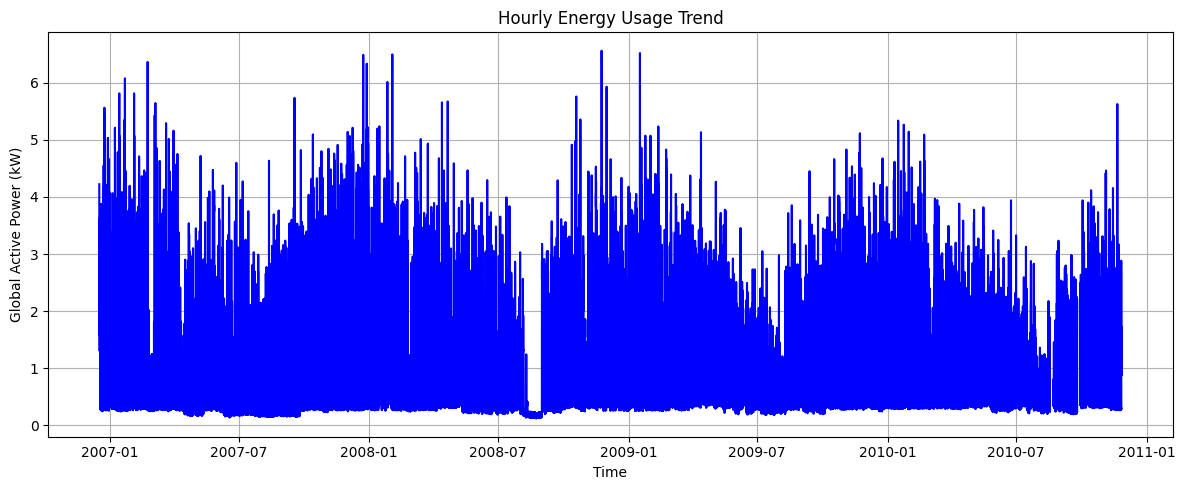

In [77]:
plot_energy_trend(df_hourly, "Hourly Energy Usage Trend" )

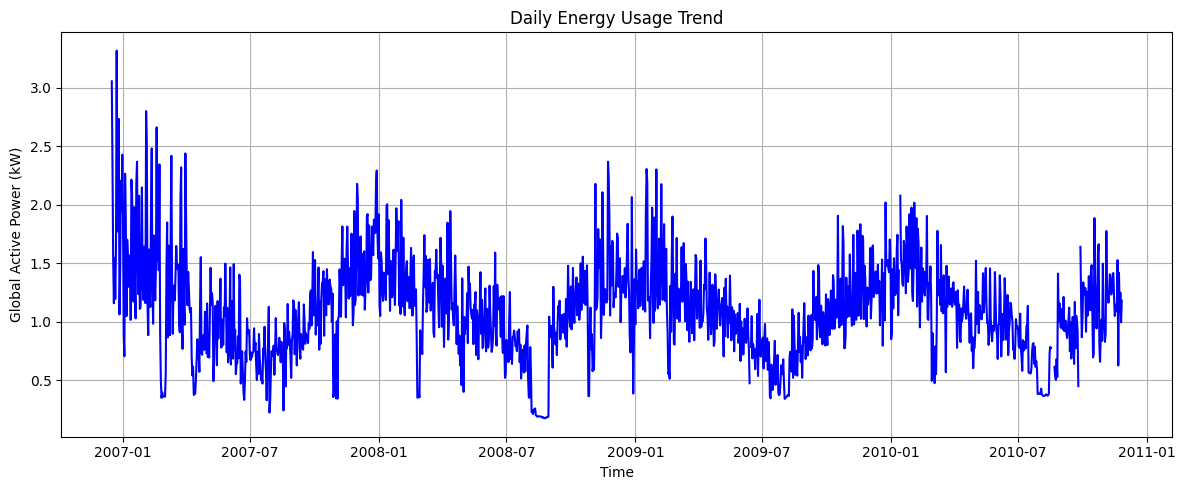

In [78]:
plot_energy_trend(df_daily, "Daily Energy Usage Trend" )

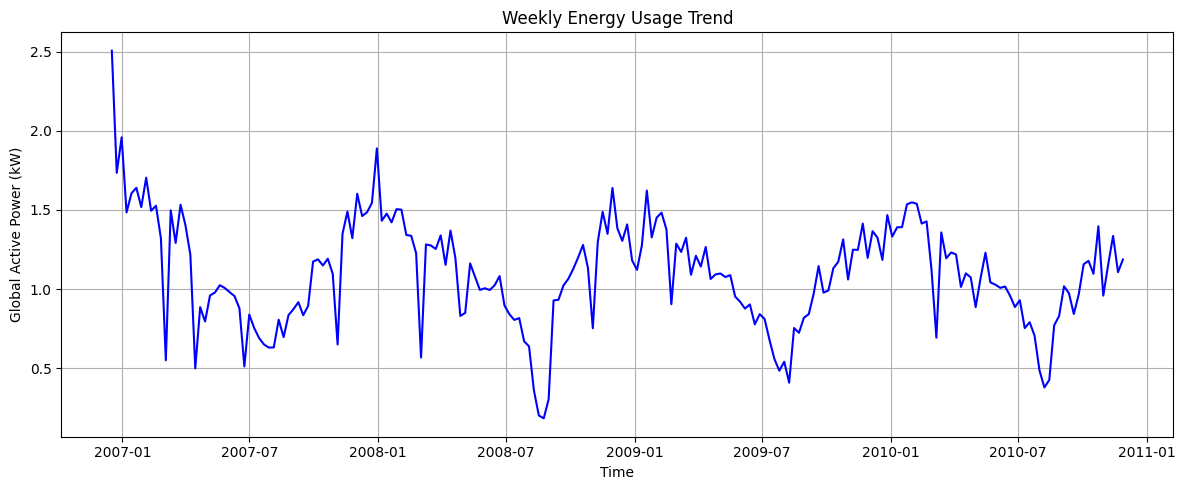

In [79]:
plot_energy_trend(df_weekly, "Weekly Energy Usage Trend" )

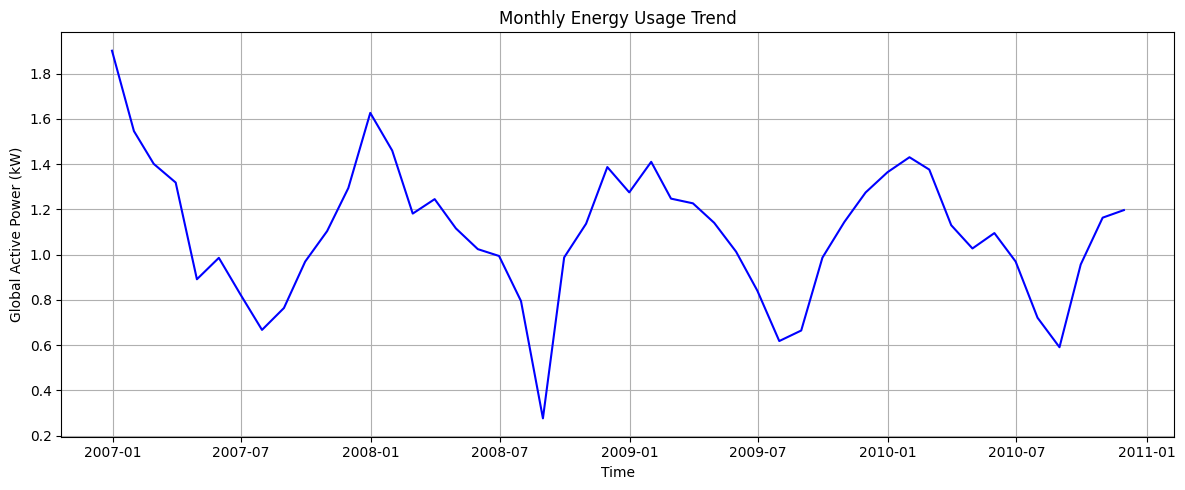

In [80]:
plot_energy_trend(df_monthly, "Monthly Energy Usage Trend" )

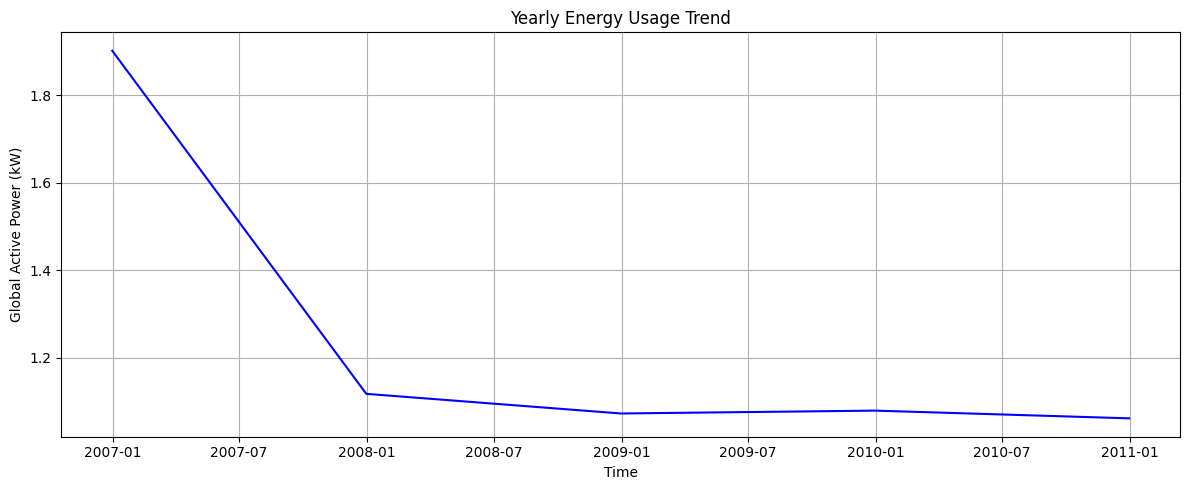

In [81]:
plot_energy_trend(df_yearly, "Yearly Energy Usage Trend" )

#### Plot Outliers / Peak Time (BoxPlot)

In [82]:
import calendar

def plot_outliers_boxplot(df_resampled, time_unit, title="Boxplot of Energy Usage"):

   df_plot = df_resampled.copy()

   if time_unit == "hour":
    df_plot["time_unit"] = df_plot.index.hour
   elif time_unit == "day":
    df_plot["time_unit"] = df_plot.index.dayofweek
    df_plot['time_unit'] = df_plot['time_unit'].apply(lambda x: calendar.day_name[x])
   elif time_unit == "week":
    df_plot['time_unit'] = df_plot.index.isocalendar().week.astype(int)
   elif time_unit == "month":
    df_plot["time_unit"] = df_plot.index.month
   elif time_unit == "year":
    df_plot["time_unit"] = df_plot.index.year
   else:
    raise ValueError("Unsupported time_unit")

   plt.figure(figsize=(12,5))
   sns.boxplot(x='time_unit', y='Global_active_power', data=df_plot)
   plt.title(title)
   plt.xlabel(time_unit)
   plt.ylabel("Global Active Power (kW)")
   plt.tight_layout()
   plt.show()

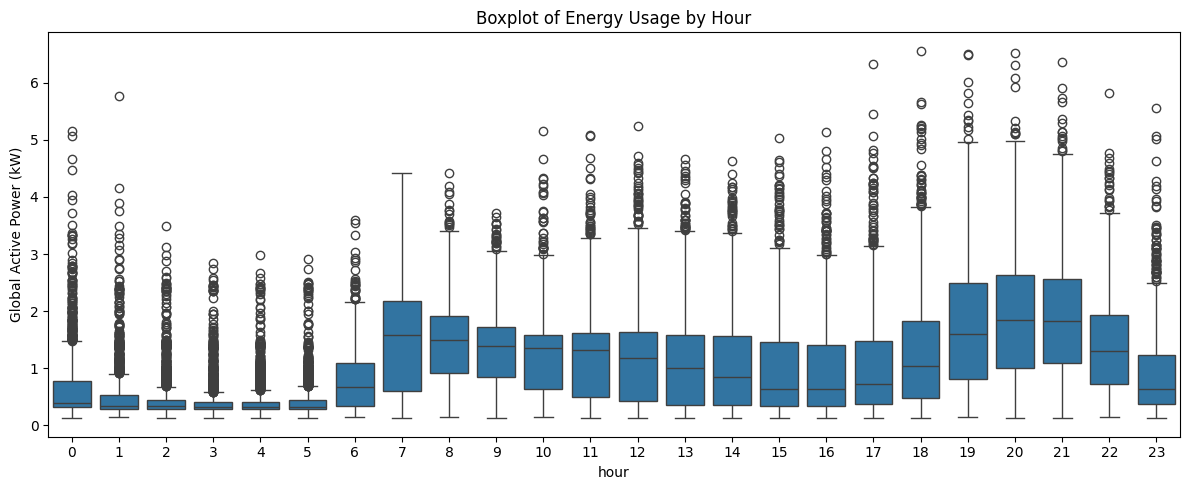

In [83]:
plot_outliers_boxplot(df_hourly, "hour", "Boxplot of Energy Usage by Hour")

High variability and outliers from ~17:00 to 21:00 (peak hours).

Low energy usage during early morning hours (0:00–5:00).

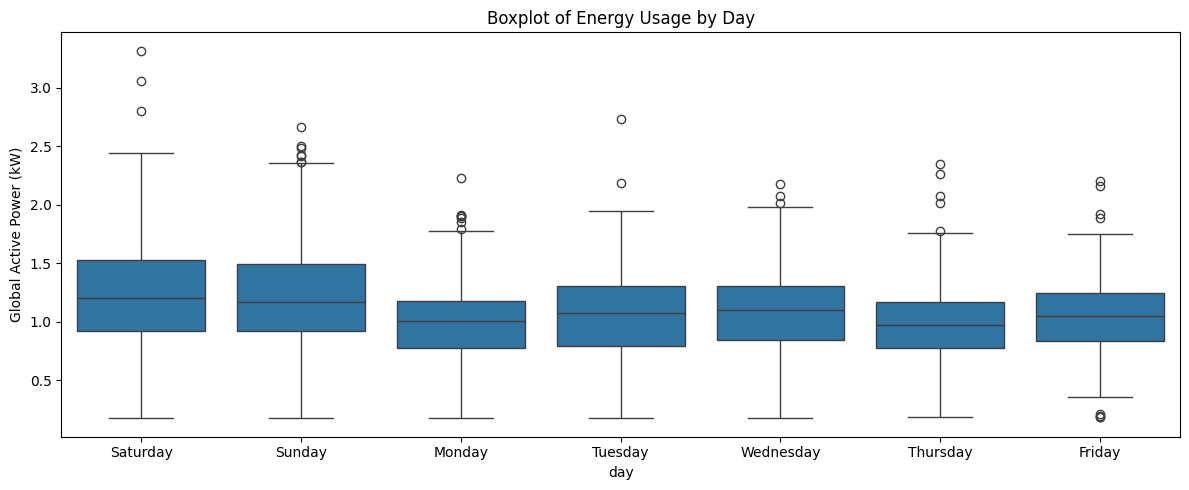

In [84]:
plot_outliers_boxplot(df_daily, "day", "Boxplot of Energy Usage by Day")

Fairly uniform usage across the week.

Slight dip midweek (Tuesday–Thursday).

Slight peak on weekends.

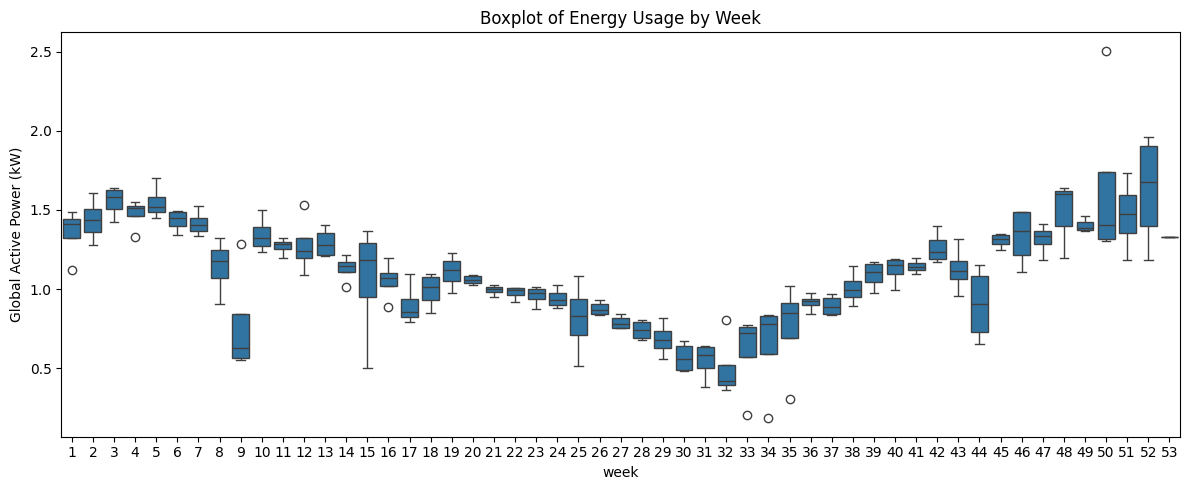

In [85]:
plot_outliers_boxplot(df_weekly, "week", "Boxplot of Energy Usage by Week")

Strong seasonal pattern: energy usage dips around week 20–35 (approx. May–August), then rises toward year-end.

Possible vacation/holiday period in the middle of the year.

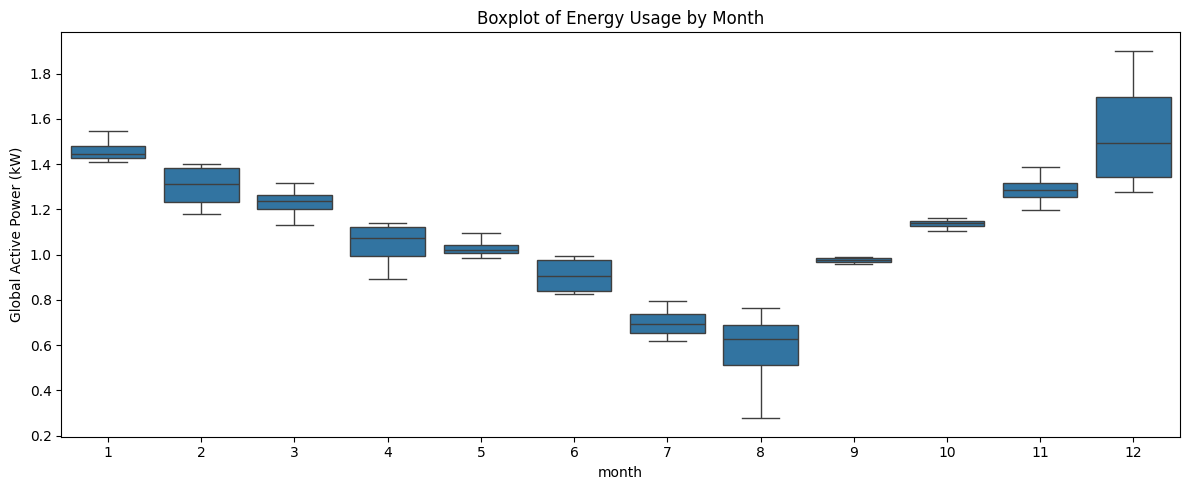

In [86]:
plot_outliers_boxplot(df_monthly, "month", "Boxplot of Energy Usage by Month")

Clear rising trend toward end of year.

Low usage: May–July.

High usage: October–December.

#### Correlation Heatmap Between All Sensors

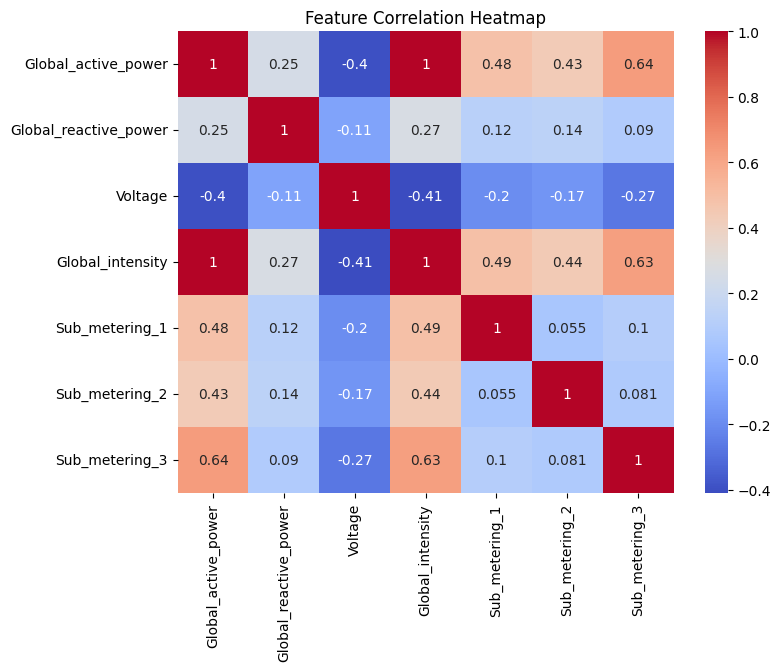

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [88]:
import plotly.express as px

fig = px.line(df_daily, x=df_daily.index, y='Global_active_power', title='Interactive Daily Energy Usage')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Plot Trend, Seasonality, and Rolling Averages

To understand how power usage varies over time:

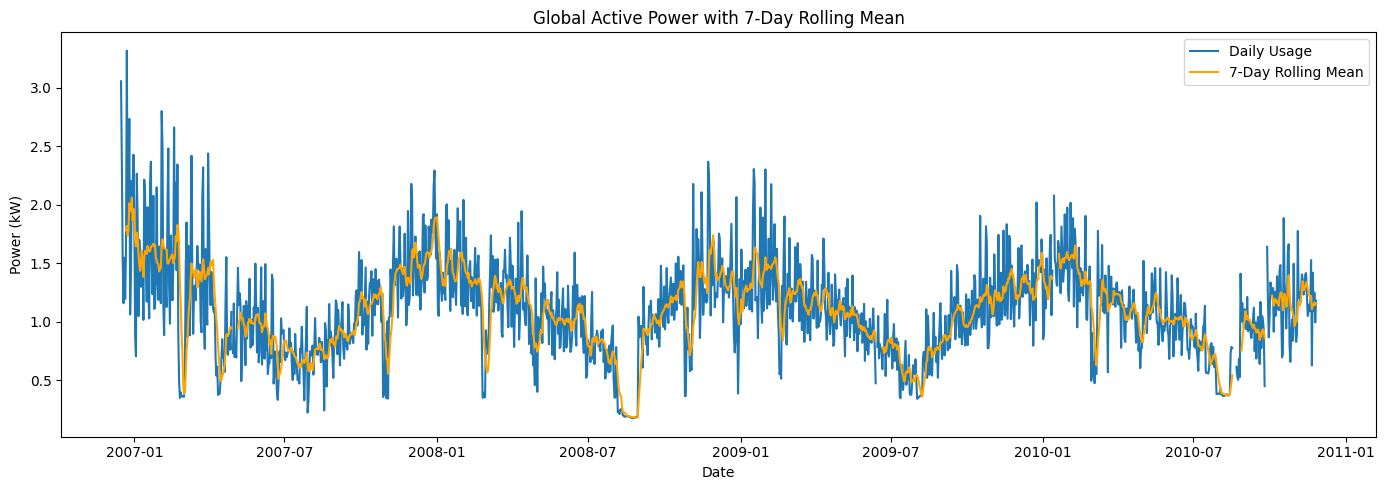

In [89]:
df_daily['rolling_7'] = df_daily['Global_active_power'].rolling(7).mean()

plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Daily Usage')
plt.plot(df_daily.index, df_daily['rolling_7'], label='7-Day Rolling Mean', color='orange')
plt.title('Global Active Power with 7-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

## Feature Engineering

1. Time-based Features (From Datetime Index)

In [90]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

/tmp/ipython-input-90-3176706925.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-90-3176706925.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-90-3176706925.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-

 2. Lag Features (past values of target)

 These give the model memory of recent power usage.

In [91]:
df['lag_1'] = df['Global_active_power'].shift(1)    # 1 min ago
df['lag_60'] = df['Global_active_power'].shift(60)  # 1 hour ago
df['lag_1440'] = df['Global_active_power'].shift(1440)  # 1 day ago

/tmp/ipython-input-91-1040627556.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-91-1040627556.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-91-1040627556.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3. Rolling Mean and Std

 Rolling Mean	Smooths out fluctuations, helps detect trend

 Rolling Std	Captures short-term volatility helpful for anomaly detection

 "Rolling" means sliding window statistics. Instead of computing the mean over the entire dataset, you compute the mean and standard deviation over the last n hours (24h in our case).

 This gives you:

- A smoothed version of power usage over 24 hours

- A way to track recent local trends

- A basis for saying: “If current usage > recent average + 2×std → that’s suspicious!”

In [92]:
# Rolling mean and std over 24 hours (1440 min)
df['rolling_mean_1440'] = df['Global_active_power'].rolling(window=1440).mean()
df['rolling_std_1440']  = df['Global_active_power'].rolling(window=1440).std()

/tmp/ipython-input-92-3500267323.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-92-3500267323.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Visualize with Rolling Features

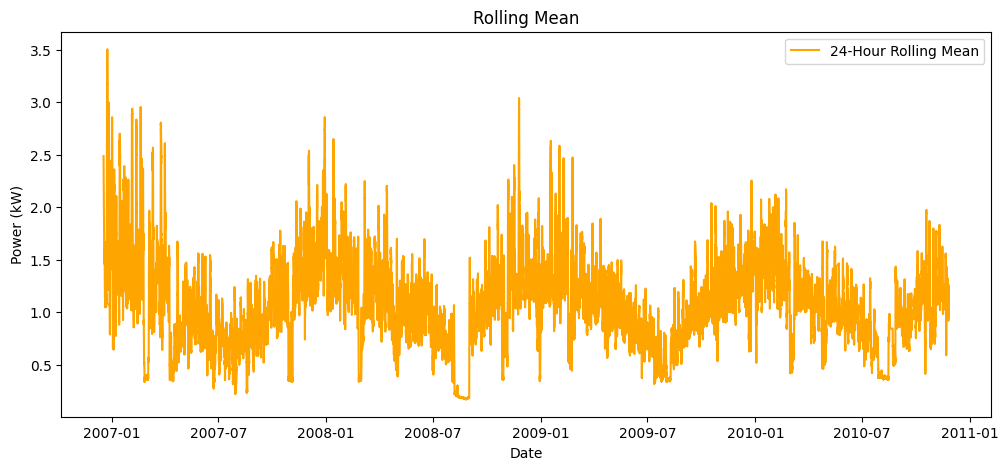

In [93]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['rolling_mean_1440'], label = '24-Hour Rolling Mean', color = 'orange')
plt.title('Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()

Peaks often in:

Winter months → possibly due to heating or longer lighting hours.

Certain weekday patterns or household routines.

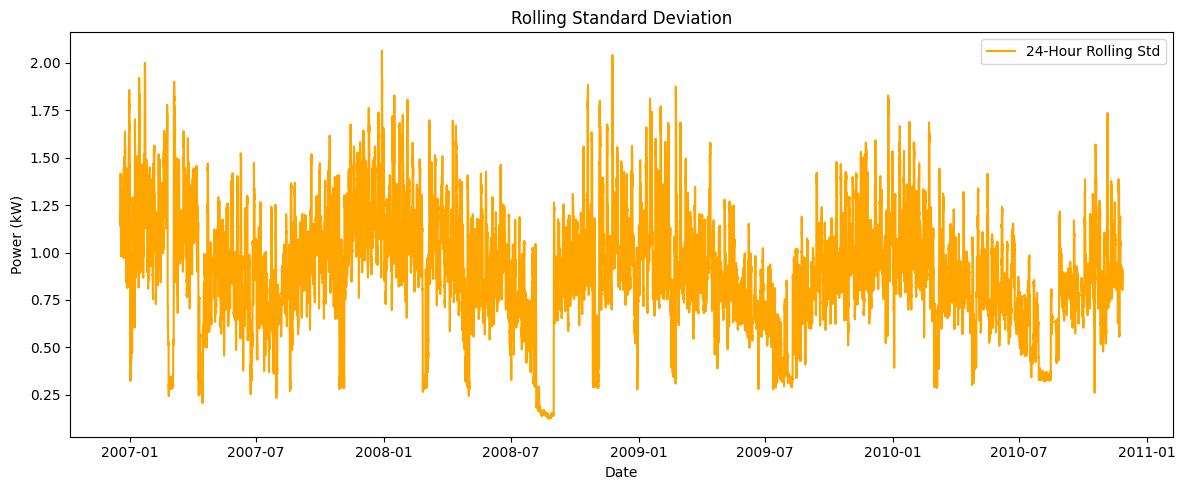

In [94]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['rolling_std_1440'], label = '24-Hour Rolling Std', color = 'orange')
plt.title('Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

#### Anomaly Detection Using Rolling Mean + Std


Anomaly detection is useful because it helps you identify abnormal energy usage patterns that may point to:

##### Situation	Example:
- Appliance fault	A heater stuck in ON mode all night

- Unexpected demand spike	Too many devices running at once

- Power wastage	Lights/fans running when no one's home

- Data errors	Sensor malfunction or bad readings

In [95]:
# Define a threshold based on 24h rolling mean + 2× std:
threshold = df['rolling_mean_1440'] + 5 * df['rolling_std_1440']

In [96]:
anomalies = df[df['Global_active_power']> threshold]

/tmp/ipython-input-97-979032850.py:5: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



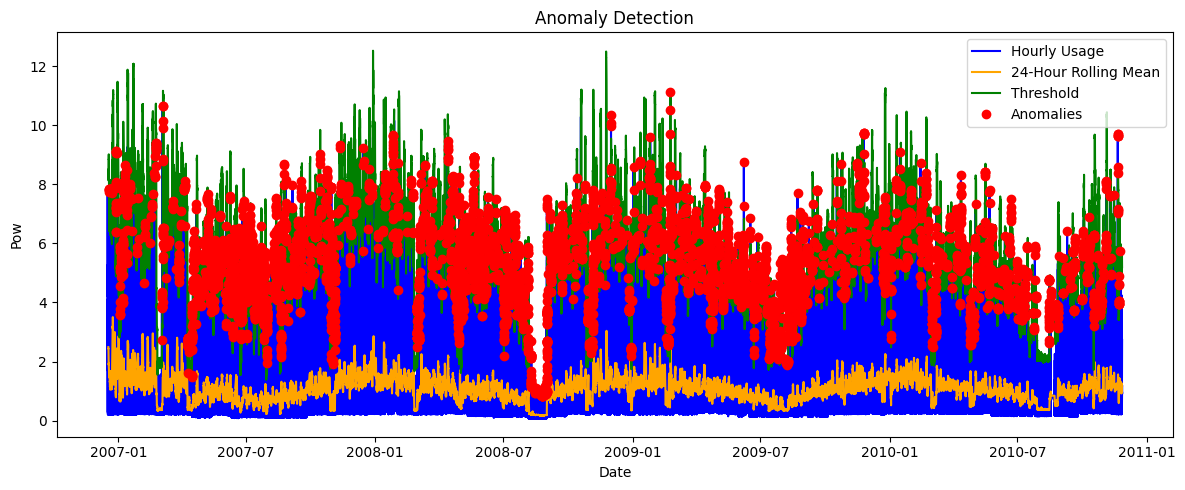

In [97]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Global_active_power'], label = 'Hourly Usage', color = 'blue')
plt.plot(df.index, df['rolling_mean_1440'], label = '24-Hour Rolling Mean', color = 'orange')
plt.plot(df.index, threshold, label = 'Threshold', color = 'green')
plt.plot(anomalies.index, anomalies['Global_active_power'], 'ro', label = 'Anomalies', color = 'red')
plt.title('Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Pow')
plt.tight_layout()
plt.legend()
plt.show()

Frequent anomalies during:

Evening hours (likely peak appliance time)

Certain seasonal transitions (e.g., Jan–Feb or Sep–Oct)

These points can trigger:

Usage alerts

Maintenance checks

Automated appliance scheduling systems

In [98]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,is_weekend,lag_1,lag_60,lag_1440,rolling_mean_1440,rolling_std_1440
DateTime,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,5,12,2006,1,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,5,12,2006,1,4.216,NaN,NaN,NaN,NaN
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,5,12,2006,1,5.360,NaN,NaN,NaN,NaN
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,5,12,2006,1,5.374,NaN,NaN,NaN,NaN
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,5,12,2006,1,5.388,NaN,NaN,NaN,NaN


In [99]:
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
hour,0
dayofweek,0
month,0


In [100]:
df = df.dropna()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,is_weekend,lag_1,lag_60,lag_1440,rolling_mean_1440,rolling_std_1440
DateTime,,,,,,,,,,,,,,,,,
2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,17,6,12,2006,1,3.238,4.864,4.216,2.487154,1.201382
2006-12-17 17:25:00,3.360,0.164,231.20,14.4,0.0,0.0,16.0,17,6,12,2006,1,3.390,4.868,5.360,2.485765,1.199212
2006-12-17 17:26:00,3.400,0.162,232.86,14.6,0.0,0.0,17.0,17,6,12,2006,1,3.360,4.876,5.374,2.484394,1.197035
2006-12-17 17:27:00,3.396,0.164,232.89,14.6,0.0,0.0,17.0,17,6,12,2006,1,3.400,4.810,5.388,2.483011,1.194826
2006-12-17 17:28:00,3.282,0.100,232.33,14.0,0.0,0.0,16.0,17,6,12,2006,1,3.396,4.790,3.666,2.482744,1.194605


#### Outlier Removal

Now, before modeling (like Prophet, XGBoost, LSTM), you remove those outliers to:

- Improve forecast accuracy

- Avoid bias from rare, extreme events

- Ensure smoother trends for models to learn from

In [101]:
features = ['hour', 'dayofweek', 'month', 'year','is_weekend',
            'lag_1', 'lag_60', 'lag_1440',
            'rolling_mean_1440', 'rolling_std_1440', 'Global_active_power',
            'Global_reactive_power', 'Voltage', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [102]:
for feature in features:
  upper = df[feature].quantile(0.99)
  df_clean = df[df[feature] <= upper]

In [103]:
df_clean.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,is_weekend,lag_1,lag_60,lag_1440,rolling_mean_1440,rolling_std_1440
DateTime,,,,,,,,,,,,,,,,,
2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,17,6,12,2006,1,3.238,4.864,4.216,2.487154,1.201382
2006-12-17 17:25:00,3.360,0.164,231.20,14.4,0.0,0.0,16.0,17,6,12,2006,1,3.390,4.868,5.360,2.485765,1.199212
2006-12-17 17:26:00,3.400,0.162,232.86,14.6,0.0,0.0,17.0,17,6,12,2006,1,3.360,4.876,5.374,2.484394,1.197035
2006-12-17 17:27:00,3.396,0.164,232.89,14.6,0.0,0.0,17.0,17,6,12,2006,1,3.400,4.810,5.388,2.483011,1.194826
2006-12-17 17:28:00,3.282,0.100,232.33,14.0,0.0,0.0,16.0,17,6,12,2006,1,3.396,4.790,3.666,2.482744,1.194605


## Model Training

In [104]:
# Slice the dataset
df_clean = df.tail(50000)

In [105]:
# Prepare sequences

def create_lstm_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Use only the target column
series = df_clean['Global_active_power'].values
window_size = 60  # past 60 minutes

X_lstm, y_lstm = create_lstm_dataset(series, window_size)

# Reshape for LSTM [samples, time steps, features]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

In [106]:
# Train LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_lstm, y_lstm, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1561/1561 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 2.6635
Epoch 2/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0649
Epoch 3/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0558
Epoch 4/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0558
Epoch 5/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0566
Epoch 6/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0562
Epoch 7/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0523
Epoch 8/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0542
Epoch 9/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0531
Epoch 10/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 0.0548


In [107]:
# Make Predictions
next_input = series[-window_size:].reshape(1, window_size, 1)
predicted_value = model_lstm.predict(next_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


##### Calculate Accuracy

In [108]:
y_pred_lstm = model_lstm.predict(X_lstm[-1440:])  # last 1-day for example
y_true_lstm = y_lstm[-1440:]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_lstm = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_true_lstm - y_pred_lstm.flatten()) / y_true_lstm)) * 100

print(f"LSTM RMSE: {rmse_lstm:.3f}")
print(f"LSTM MAE: {mae_lstm:.3f}")
print(f"LSTM MAPE: {mape_lstm:.2f}%")

LSTM RMSE: 0.178
LSTM MAE: 0.066
LSTM MAPE: 5.39%


RMSE:	0.178	Average prediction error is ~0.178 kW — low error magnitude

MAE:	0.066	Average absolute error is tiny — great for consistent prediction

MAPE:	5.39%	Only ~5.3% deviation from actual — excellent in forecasting terms

## Visualize Predictions

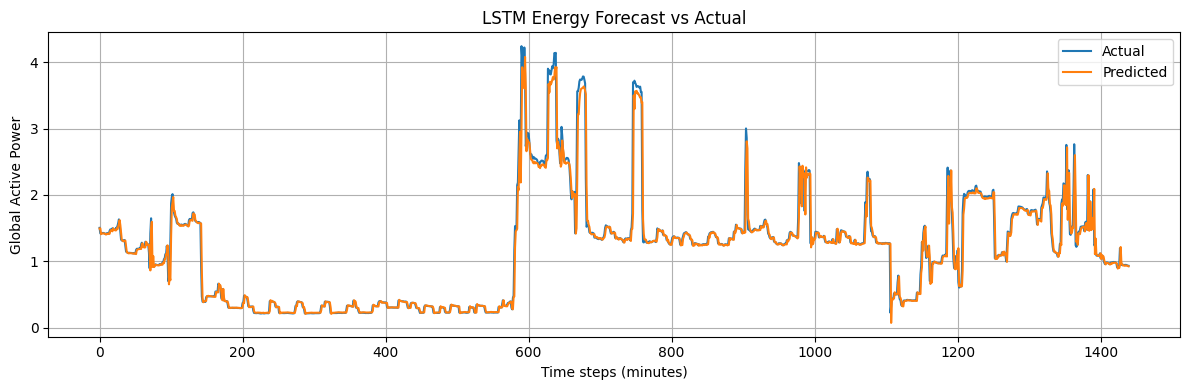

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_true_lstm, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title("LSTM Energy Forecast vs Actual")
plt.xlabel("Time steps (minutes)")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Save the Model

In [111]:
import pickle


## Save Cleaned Data to CSV

In [112]:
df_clean.to_csv("clean_energy_data.csv")